# Covid-19 Prediction Model Project

# Introduction

**Purpose of Project**

In this hackathon, we want you to build machine learning models to predict COVID-19 infections from symptoms. It has several applications – for example, triaging patients to be attended by a doctor or nurse, recommending self-isolation through contact tracing apps, etc.

**Problem Statement**

This is a classifier problem as we want to either:
1. Predict the test result from our features
2. Predict the likihood of a positive result from our features

We might also want to consider who is at greater risk. For example,
* Risk of complications is more likely in over 60s
* A shortness of breath might be a more worrying symptom than sore throat

## Libraries
As always, we'll start by importing the necessary libraries.

In [6]:
# It's good practice to add comments to explain your code 
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
# Add your code here
data = pd.read_csv('data/corona_tested_individuals_ver_006.english.csv', dtype={'age_60_and_above': str})
data['test_date'] = pd.to_datetime(data['test_date'] )

data['test_day'] = data['test_date'].dt.day
data['test_weekday'] = data['test_date'].dt.weekday
data['test_month'] = data['test_date'].dt.month

data.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,test_day,test_weekday,test_month
0,2020-04-30,0.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other,30,3,4
1,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other,30,3,4
2,2020-04-30,0.0,1.0,0.0,0.0,0.0,negative,NaN,male,Other,30,3,4
3,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,female,Other,30,3,4
4,2020-04-30,1.0,0.0,0.0,0.0,0.0,negative,NaN,male,Other,30,3,4


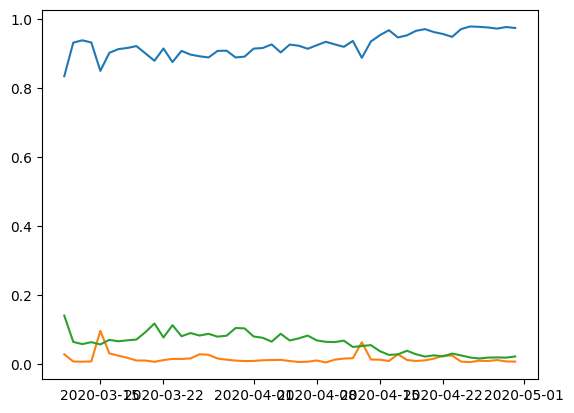

In [8]:
# what is the trend of results over time?

test = data.pivot_table(index = ['test_date'], 
                        columns = ['corona_result'], 
                        values = ['test_indication'], 
                        aggfunc = 'count' , margins = 'all')

test.columns = ['neg','pos','other','all']

test.head()
test = test.iloc[:-1,:]
test['perc_neg'] = test['neg'] / test['all']
test['perc_pos'] = test['pos'] / test['all']
test['perc_other'] = test['other'] / test['all']
test.head()
plt.plot(test['perc_neg'])
plt.plot(test['perc_pos'])
plt.plot(test['perc_other'])
plt.show()        



**Question 1**

Descibe the dataset

- There are 278,848 observations

Exploratory Data Analysis

Think about possible biases and limitations of this dataset. What are the sources of uncertainty?
* What is the format of feature values?
* What is the statistics of these feature values? How many symptoms are reported or not?
* Which symptoms have a reporting bias, i.e., likely to be reported when the patient is COVID positive?
* How will the symptoms with reporting bias affect the model’s performance?
* Visualization: Draw the bar graph of features grouped by the target class?
* What does the bar graph of the symptoms with reporting bias look like?
* Determine if we have a class imbalance in the dataset? If so, what do you reckon will be the downstream challenges in evaluating the model? How will you overcome those challenges?

In [9]:
# data.info()

In [10]:
# data.isna().sum()

## Observations

| Columns            | dtype    | Null Count | Thoughts |
|--------------------|----------|------------|----------|
| test_date          |  datetime|           0| We need to look at the trending over time and if that effects result|
| cough              |   float  |         252| |
| fever              |    float |         252| |
| sore_throat        |    float |           1| |
| shortness_of_breath|  float   |           1| |
| head_ache          |   float  |           1| |
| corona_result      |   object |           0| we have 93% negatives so need to be careful here |
| age_60_and_above   | object   |      127320| we could look to remove this feature in the initial model; we could change to categorical: under 60, over 60 and missing |
| gender             | object   |       19563| we could look to remove this feature in the initial model |
| test_indication    |  object  |           0| |

* There are 278,848 observations
* We need to look at the null data within the positive dataset to see how much of an impact the null values have on the result
* We should consider SMOTE for our null float values

In [11]:
# what about cough?

test = data.groupby(['corona_result','cough'], dropna = False).size().reset_index(name = 'count')
test['result_sum'] = test.groupby(['corona_result'])['count'].transform('sum')
test['result_perc'] = round(test['count'] / test['result_sum'] * 100, 2)
test
# print('''
# Observation:
# * ''')

,corona_result,cough,count,result_sum,result_perc
0,negative,0.0,225021,260227,86.47
1,negative,1.0,34987,260227,13.44
2,negative,NaN,219,260227,0.08
3,other,0.0,3235,3892,83.12
4,other,1.0,657,3892,16.88
5,positive,0.0,8112,14729,55.08
6,positive,1.0,6584,14729,44.70
7,positive,NaN,33,14729,0.22


In [12]:
# Pre-Processing
# remove nulls from sore_throat, shortness_of_breath and head_ache as there will be little impact on the outcome
df = data.copy()
df = df.dropna(subset=['sore_throat', 'shortness_of_breath', 'head_ache'])
df.isna().sum()

test_date                   0
cough                     251
fever                     251
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age_60_and_above       127319
gender                  19562
test_indication             0
test_day                    0
test_weekday                0
test_month                  0
dtype: int64

In [13]:
# now one hot encode age 60 and gender
df['age_60_and_above'] = df['age_60_and_above'].fillna('missing')
df['gender'] = df['gender'].fillna('missing')
df['cough'] = df['cough'].fillna('missing')
df['fever'] = df['fever'].fillna('missing')

one_hot_encoded_data = pd.get_dummies(df, columns = ['age_60_and_above','gender','cough','fever','test_indication'])
#display(one_hot_encoded_data.sample(10))
one_hot_encoded_data.isna().sum()

test_date                                 0
sore_throat                               0
shortness_of_breath                       0
head_ache                                 0
corona_result                             0
test_day                                  0
test_weekday                              0
test_month                                0
age_60_and_above_No                       0
age_60_and_above_Yes                      0
age_60_and_above_missing                  0
gender_female                             0
gender_male                               0
gender_missing                            0
cough_0.0                                 0
cough_1.0                                 0
cough_missing                             0
fever_0.0                                 0
fever_1.0                                 0
fever_missing                             0
test_indication_Abroad                    0
test_indication_Contact with confirmed    0
test_indication_Other           

In [ ]:
# for each feature do we see a change in positive results over time?

test = one_hot_encoded_data[one_hot_encoded_data['corona_result']=='positive']

test_vals = ['sore_throat', 'shortness_of_breath', 'head_ache',
       'corona_result', 'age_60_and_above_No', 'age_60_and_above_Yes',
       'age_60_and_above_missing', 'gender_female', 'gender_male',
       'gender_missing', 'cough_1.0', 'cough_missing',
       'fever_1.0', 'fever_missing', 'test_indication_Abroad',
       'test_indication_Contact with confirmed', 'test_indication_Other']

test = test.pivot_table(index = 'test_date', values = test_vals, aggfunc = 'sum')

# plt.figure(figsize = (20,10))
# for c in test.columns:
#     plt.plot(test[c])
# plt.legend(test_vals)
# plt.show()

test

## Baseline model




In [162]:
X = one_hot_encoded_data.drop(columns = ['corona_result','test_date'])
y = one_hot_encoded_data['corona_result']

In [189]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size= 0.8 ,stratify = y)

In [200]:
print(set(y_train))
print(set(y_test))

In [191]:
lr = LogisticRegression()


In [192]:
lr.fit(X_train, y_train)

In [193]:
y_pred = lr.predict(X_test)

In [194]:
accuracy = accuracy_score(y_test, y_pred)
print('Model Accuracy:', accuracy)

This looks really good! But what about against each result?

In [195]:
set(y_train)

In [201]:
set(y_pred)

In [202]:
y_test.value_counts()

In [198]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')

In [199]:
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot = True, fmt = '.2%', cmap = 'Blues');

In [208]:
class_report = classification_report(y_test, y_pred)
print(class_report)

In [210]:
feature_importance = pd.DataFrame({'Feature': X.columns,
                                  'Importance': lr.coef_[0]}).sort_values(by = 'Importance', 
                                                                          ascending = False)

feature_importance

In [49]:
# lets one hot encode age_60_and_above to '60_and_above', 'under_60', 'unknown'

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define preprocessing steps
preprocessor = StandardScaler()

# Define the model
model = LogisticRegression()

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Assume X_train and y_train are your data
# pipeline.fit(X_train, y_train)

In [212]:
for c in data.columns[1:]:
    print(c)
    if c == 'corona_result':
        pass
    else:
        plt.title(c)
        for a in one_hot_encoded_data.corona_result.unique():
            try:
                plt.hist(one_hot_encoded_data[one_hot_encoded_data.corona_result == a][c], bins = 2)
            except:
                pass
        plt.show()
    